# Weak instruments

We've all heard that the rule of thumb for strong instruments is $F > 10$ (though troubling [recent work](https://arxiv.org/pdf/2010.05058.pdf) suggests that F might need to be much, much larger...). Let's explore in code the weak instruments problem, by examining the bias and precision of IV estimates in the just-identified case.

First, we need to specify data-generating processes. The first stage is where we need to be careful. Remembering our goal, we need a data-generating process that is able to vary parameters that changes how weak the instrument is, AND how many instruments there are. Lets call $K$ the number of insturuments. We will change how weak the instruments are by varying the vector $\pi$ in the equation:

$$x_i = \pi Z_i + v_i$$

Intuitively, weak instruments will have $\pi\to 0$. For simplicity, let's assume (for now) $\pi_k = \pi\: \forall\: k$.

In [1]:
import numpy as np
import scipy.stats.distributions as iid
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
# DGP: y, x
def dgp(N, beta, pi):
    # we need values of X that are correlated with both Z and U
    # generate values of X, u that are correlated
    means_XUZ = [0, 5, 0]
    covar_XUZ = [[2.0, 0.8, 0.5], 
                 [0.8, 0.5, 0],
                 [0.5, 0, 1*(1/pi)]]
    XUZ = scipy.stats.multivariate_normal(means_XUZ, covar_XUZ).rvs(size=N)
    # create Y
    X = XUZ[:,[0]]
    Y = beta*X + XUZ[:,[1]] # use brackets to force output array to be (N,1) instead of (N,)
    Z = XUZ[:,[2]]
    
    return Y, X, Z

In [3]:
N = int(1e3)
true_beta = 2
pi = 1
Y, X, Z = dgp(N, true_beta, pi)
Xi = np.c_[np.ones((N,1)), X]
Zi = np.c_[np.ones((N,1)), Z]

# test OLS regression
np.linalg.solve(Xi.T@Xi, Xi.T@Y) # beta_1 biased!

array([[4.99202794],
       [2.39725301]])

In [4]:
# test first stage
np.linalg.solve(Zi.T@Zi, Zi.T@X) # unbiased!

array([[-2.26408028e-04],
       [ 4.99825860e-01]])

In [5]:
# test IV
np.linalg.solve(Zi.T@Xi, Zi.T@Y) # unbiased!

array([[4.99955996],
       [2.02350878]])

### Check your understanding
1. I did not (explicitly) include an intercept in the DGP for Y, but I did in the regression and the resulting $\hat{\alpha}\neq 0$. Why?
2. How did I generate bias in the DGP? What is this bias a function of?
3. How is relevance ($cov(X,Z)\neq 0$ established? How did you know $E\hat{\pi} = 1$?
4. What does each term in ``covar_XUZ`` represent?

## Iterating
Now that we have our data-generating process, we can iterate over values of $\pi$, and for **each value of $\pi$** we want to:
1. Draw a sample size of N L-times
2. For each of these (L) draws, calculate the OLS and IV estimators.
3. Plot a histogram of the (L) $\hat{\beta}_l^{iv}$ and $\hat{\beta}_l^{ols}$

For good measure, let's also calculate the F statistic for each of our draws. Collecting this together in a function will help us stay organized.

In [6]:
def estimate(data):
    '''
    data: a tuple (Y, X, Z)
    Given data, estimate OLS and IV, and the first-stage F statistic.
    
    Returns: a tuple (beta_ols, beta_iv, F_1ststage)
    '''
    Y, X, Z = data
    # add intercepts
    Xi = np.c_[np.ones((N,1)), X]
    Zi = np.c_[np.ones((N,1)), Z]

    # ols
    beta_ols = np.linalg.solve(Xi.T@Xi, Xi.T@Y)
    # iv
    beta_iv = np.linalg.solve(Zi.T@Xi, Zi.T@Y)
    
    # F statistic
    # 1. need SSR (regression sum of squares)
    pi_hat = np.linalg.solve(Zi.T@Zi, Zi.T@X)
    xhat = Zi@pi_hat
    SSER = np.sum((X - X.mean())**2)
    # 2. need SSE (sum of squared errors)
    SSEF = np.sum((X - xhat)**2)
    # 3. calculate
    F = ((SSER - SSEF)/SSEF)*(len(X)-2)
    
    return beta_ols, beta_iv, F

In [7]:
# test the F statistic
from statsmodels.regression.linear_model import OLS

Y, X, Z = dgp(N, true_beta, 0.2)
Zi = np.c_[np.ones((N,1)), Z]
print()
OLS(X,Zi).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     32.84
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           1.32e-08
Time:                        12:15:08   Log-Likelihood:                -1773.5
No. Observations:                1000   AIC:                             3551.
Df Residuals:                     998   BIC:                             3561.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0558      0.045     -1.236      0.217      -0.144       0.033
x1             0.1188      0.021      5.731      0.000       0.078       0.159
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.142
Skew:                          -0.029   Prob(JB):                        0.932
Kurtosis:                       2.992   Cond. No.                         2.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

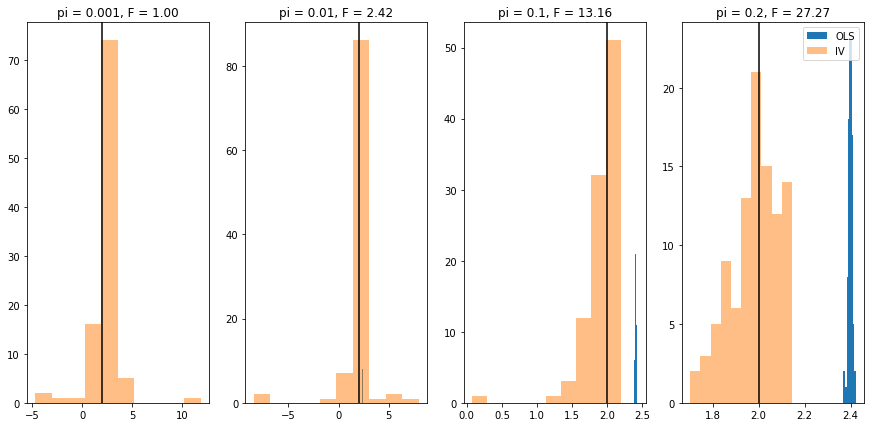

In [9]:
L = 100
N = 1000
true_beta = 2

fig, ax = plt.subplots(1, 4, figsize=(15,7))

counter = 0

for pi in [0.001, 0.01, 0.1, 0.2]:
    results = [estimate(dgp(N, true_beta, pi)) for i in range(L)]
    beta_ols = np.array([i[0][1] for i in results]).squeeze()
    beta_iv  = np.array([i[1][1] for i in results]).squeeze()
    meanF    = np.mean([i[2] for i in results])
        
    ax[counter].hist(beta_ols, fill = 'red', alpha = 1, label = 'OLS')
    ax[counter].hist(beta_iv,  fill = 'blue', alpha = 0.5, label = 'IV')
    ax[counter].set_title(f"pi = {pi}, F = {meanF:.2f}")
    
    ax[counter].axvline(x=true_beta, color='black')
    
    counter += 1
    
plt.legend(loc='upper right')